# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

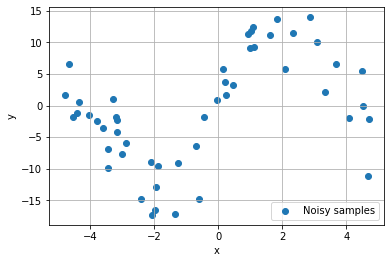

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

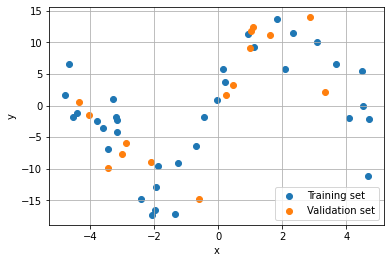

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

In [11]:
X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
X_range
model = make_model(2).fit(X_train, y_train)
model
y_pred = model.predict(X_range)

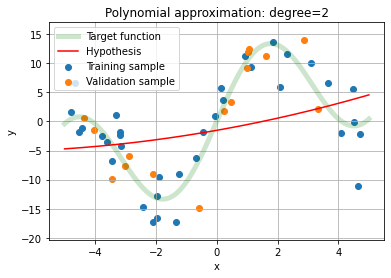

In [12]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

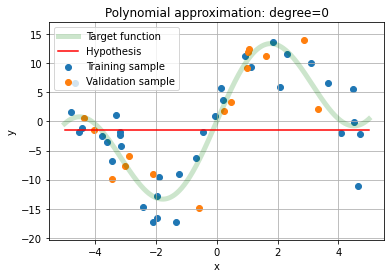

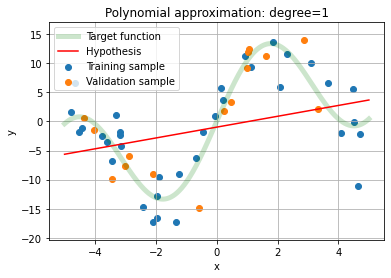

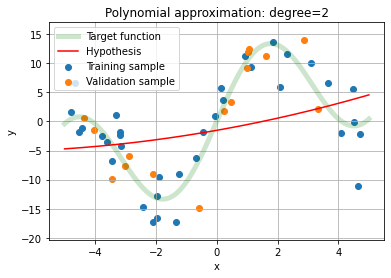

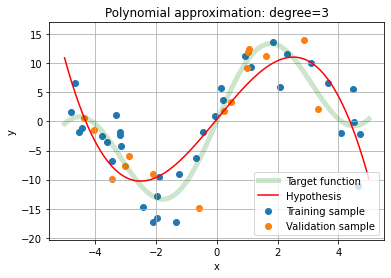

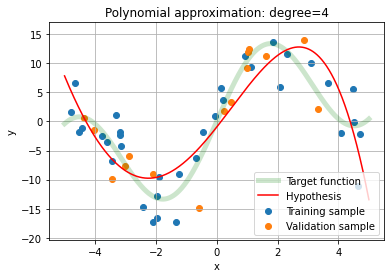

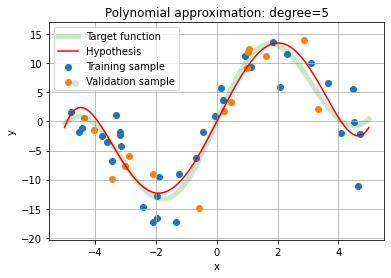

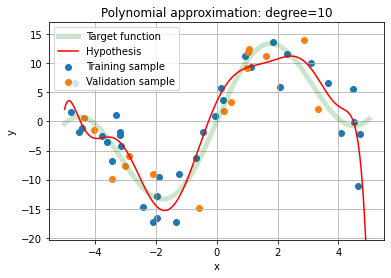

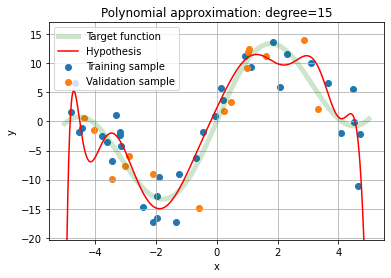

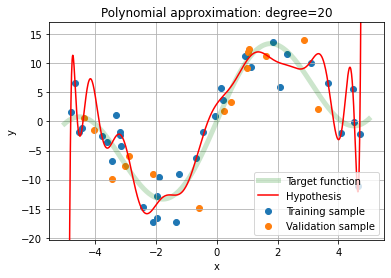

In [13]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

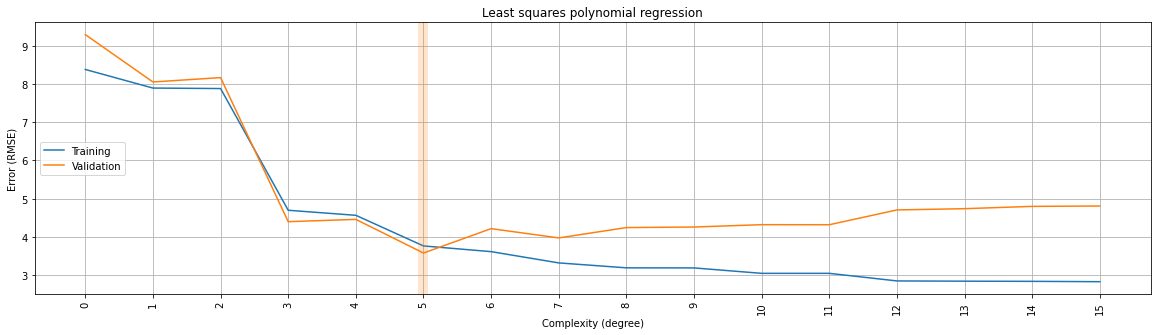

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph',
                       y_blim =None, y_tlim =None):
    plt.figure(figsize=(20, 5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')
    if y_blim:
        plt.ylim(bottom=y_blim)
    if y_tlim:
        plt.ylim(top=y_tlim)      
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [15]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

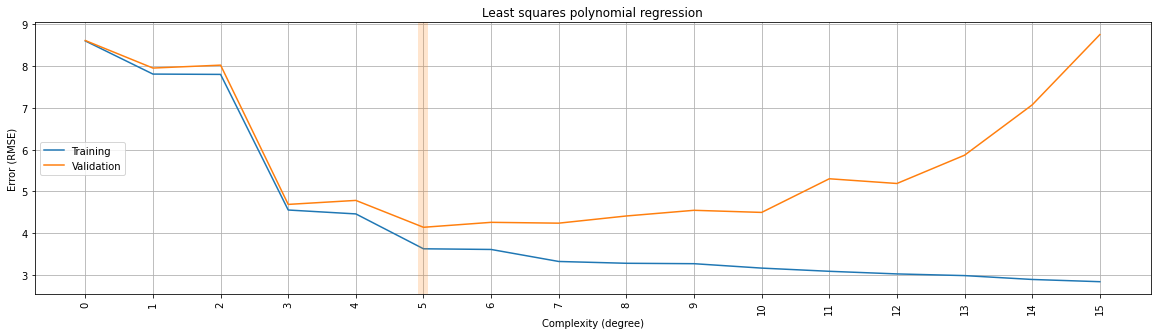

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

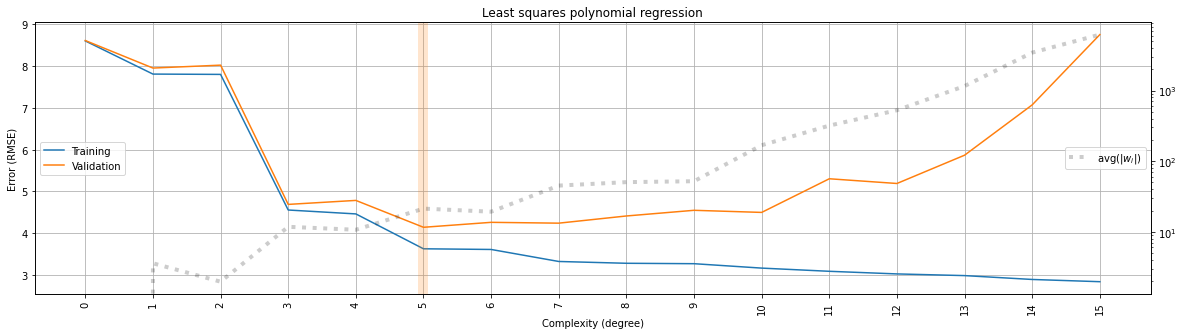

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

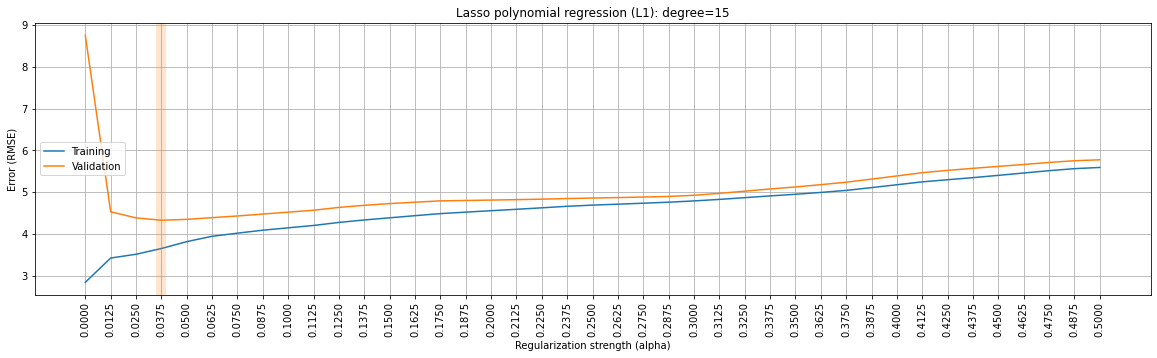

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

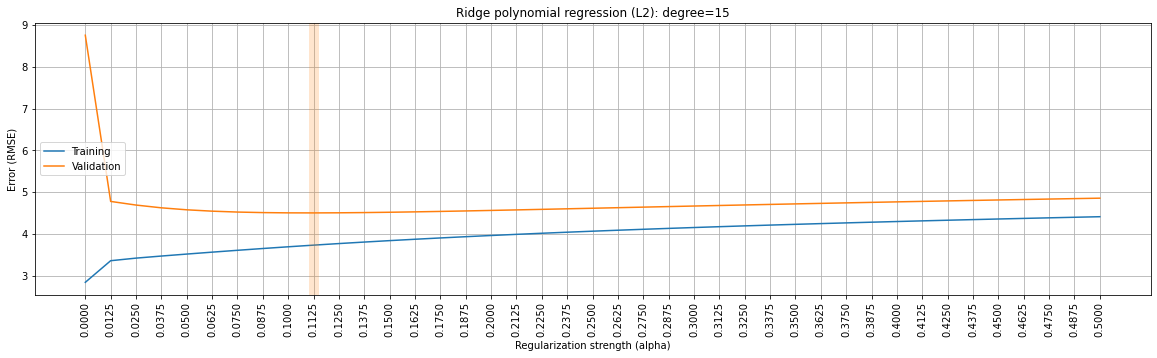

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])

print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [22]:
# your findings/conclusions

X_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [23]:
y_diabetes.head()

,target
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [24]:
print(f"X_diabetes: {X_diabetes.shape}")
print(f"y_diabetes: {y_diabetes.shape}")

X_diabetes: (442, 10)
y_diabetes: (442, 1)


In [25]:
# create training and valid vars
X_Dtrain, X_Dvalid, y_Dtrain, y_Dvalid = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state=SEED)

In [26]:
# Create Transformer

from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

def make_model_transformer(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=300000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=300000) 
    
    features_set = ['bmi', 'bp', 's6']

    PolynomialFeaturesTransform = ColumnTransformer(transformers=[('pol_transf', PolynomialFeatures(degree, include_bias=(degree == 0)), features_set)],
                                     remainder='passthrough')
    
    return Pipeline([
        ('pol', PolynomialFeaturesTransform),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model_transformer(2))
display(make_model_transformer(2, penalty='L1', alpha=0.1))
display(make_model_transformer(2, penalty='L2', alpha=0.1))    

Pipeline(steps=[('pol',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pol_transf',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 'bp', 's6'])])),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pol_transf',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 'bp', 's6'])])),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=300000, random_state=42))])

Pipeline(steps=[('pol',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pol_transf',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 'bp', 's6'])])),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=300000, random_state=42))])

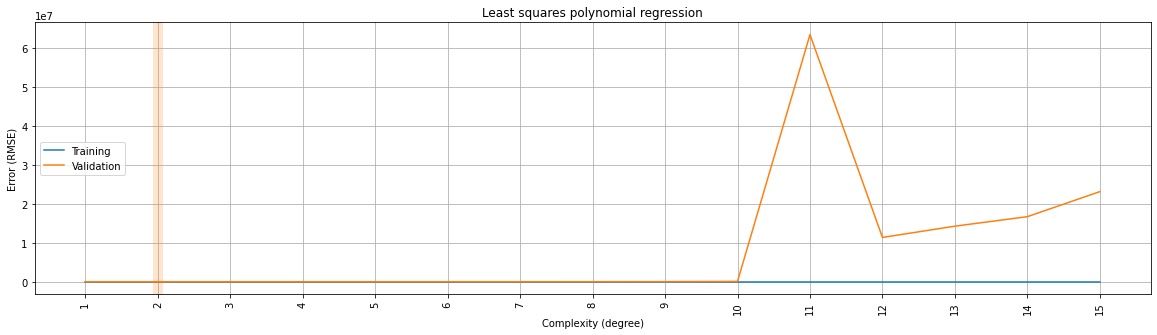

In [27]:
# Get Results

rmse_train, rmse_valid = [], []
NEW_DEGREES = range(1, 16)
for degree in NEW_DEGREES:
    reg = make_model_transformer(degree).fit(X_Dtrain, y_Dtrain)
    rmse_train.append(rmse(reg.predict(X_Dtrain), y_Dtrain))
    rmse_valid.append(rmse(reg.predict(X_Dvalid), y_Dvalid))
    
plot_fitting_graph(NEW_DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

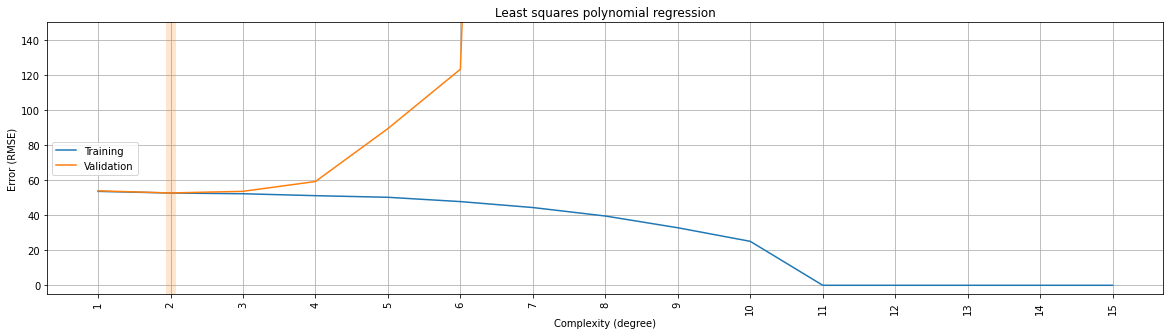

In [28]:
plot_fitting_graph(NEW_DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression', y_blim=-5, y_tlim=150)

In [29]:
NEW_DEGREES[np.argmin(rmse_valid)]

2

> We can see the following:
>
> - degree 1 is almost the same with the degree 2, so I can't say it causes underfitting.
> - degree 2 is the sweet spot because it has good both train and valid metrics. Model can capture underlying distribution well.
> - degrees > 2 have overfitting, because the fit for the validation set gets worse while the fit for the training data gets even better - that means the model starts fitting the noise in the dataset.

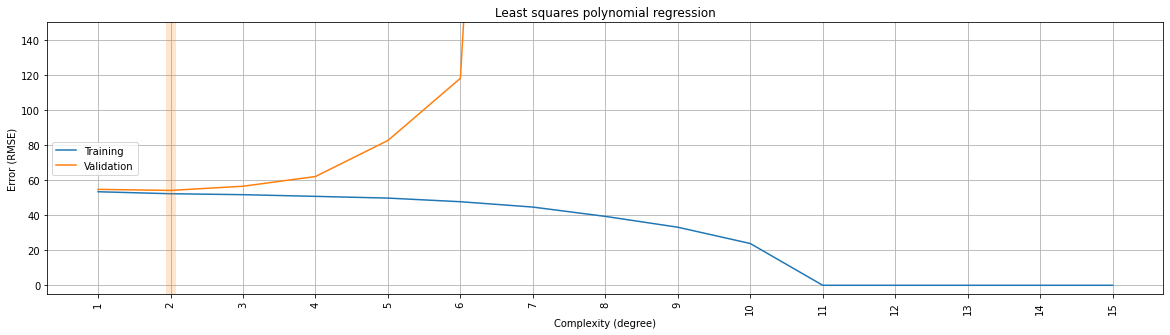

In [30]:
# Cross-validation
rmse_train, rmse_valid = [], []
for degree in NEW_DEGREES:
    results = cross_validate(make_model_transformer(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(NEW_DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression', y_blim=-5, y_tlim=150)

In [31]:
NEW_DEGREES[np.argmin(rmse_valid)]


2

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

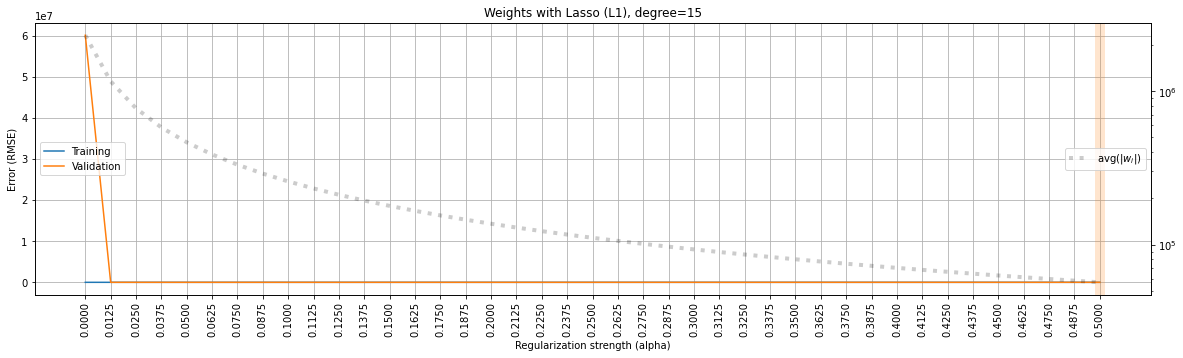

In [32]:
# your code

# Fitting graph
rmse_train, rmse_valid, L1_coefs, avg_L1_coefs = [], [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_transformer(degree=15, penalty='L1', alpha=alpha),
                             X_diabetes, y_diabetes, cv=10,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score'])) 
    L1_coefs.append([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ])
    avg_L1_coefs.append(np.mean(L1_coefs))
    
plot_fitting_graph(
    x=ALPHAS, 
    metric_train=rmse_train, 
    metric_valid=rmse_valid, 
    xlabel=f'Regularization strength (alpha)', 
    ylabel='Error (RMSE)', 
    custom_metric=avg_L1_coefs,
    custom_label='avg(|$w_i$|)',
    title='Weights with Lasso (L1), degree=15'
)

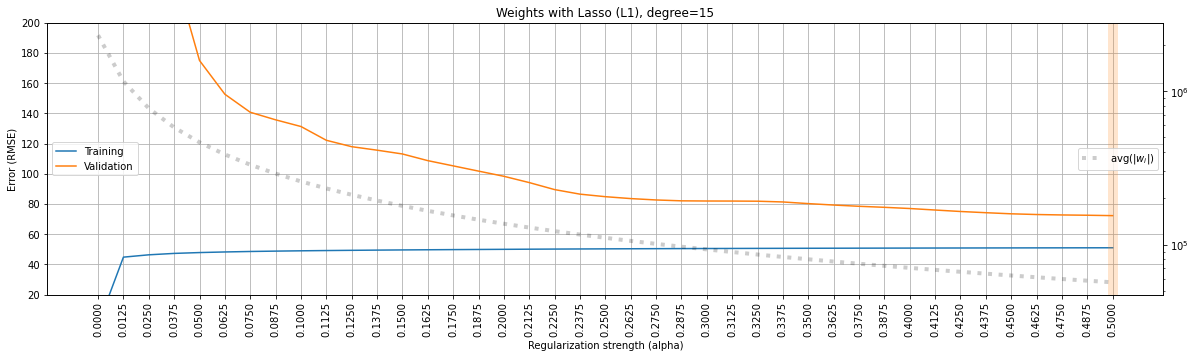

In [33]:
plot_fitting_graph(
    x=ALPHAS, 
    metric_train=rmse_train, 
    metric_valid=rmse_valid, 
    xlabel=f'Regularization strength (alpha)', 
    ylabel='Error (RMSE)', 
    custom_metric=avg_L1_coefs,
    custom_label='avg(|$w_i$|)',
    title='Weights with Lasso (L1), degree=15',
    y_blim=20,
    y_tlim=200
)

#### L2

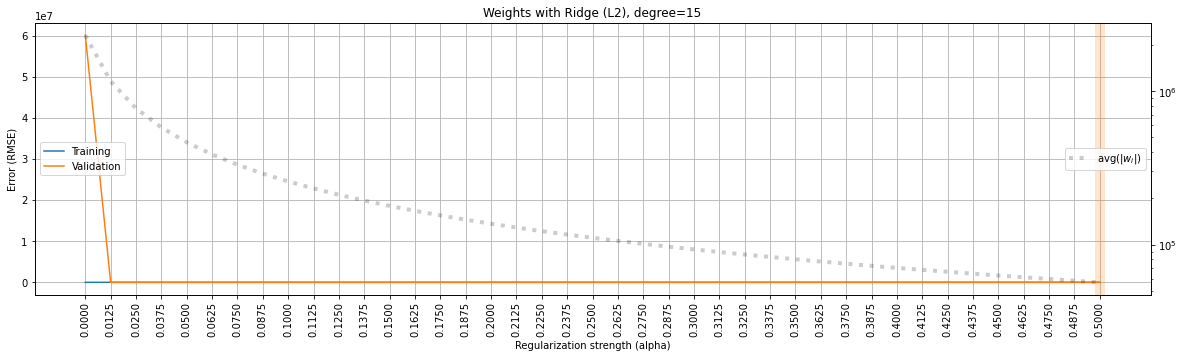

In [34]:
## your code

# Fitting graph
rmse_train, rmse_valid, L2_coefs, avg_L2_coefs = [], [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model_transformer(degree=15, penalty='L2', alpha=alpha),
                             X_diabetes, y_diabetes, cv=10,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score'])) 
    L2_coefs.append([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ])
    avg_L2_coefs.append(np.mean(L2_coefs))

plot_fitting_graph(
    x=ALPHAS, 
    metric_train=rmse_train, 
    metric_valid=rmse_valid, 
    xlabel=f'Regularization strength (alpha)', 
    ylabel='Error (RMSE)', 
    custom_metric=avg_L2_coefs,
    custom_label='avg(|$w_i$|)',
    title='Weights with Ridge (L2), degree=15'
)

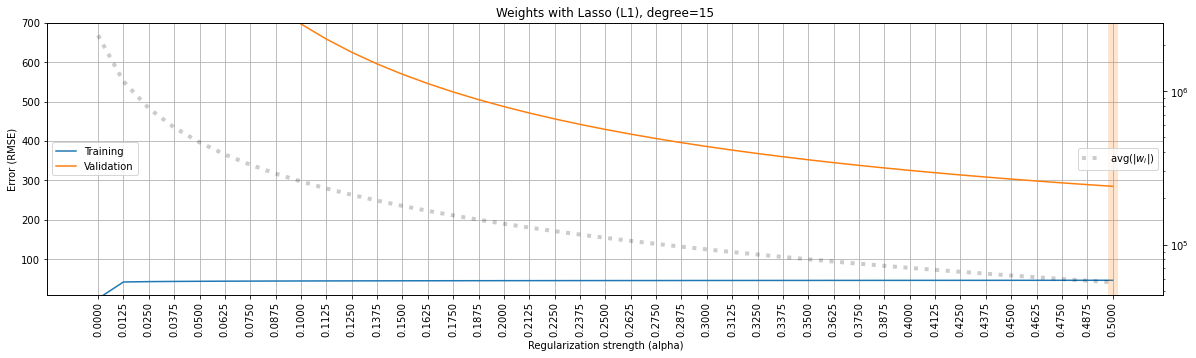

In [35]:
plot_fitting_graph(
    x=ALPHAS, 
    metric_train=rmse_train, 
    metric_valid=rmse_valid, 
    xlabel=f'Regularization strength (alpha)', 
    ylabel='Error (RMSE)', 
    custom_metric=avg_L2_coefs,
    custom_label='avg(|$w_i$|)',
    title='Weights with Lasso (L1), degree=15',
    y_blim=10,
    y_tlim=700
)

#### Summary

In [36]:
## your observations/conclusions

> After analyzing the output coefficients, we can conclude that regularization methods do indeed limit the weights (model coefficients).
> L1 encourages weights to 0.0 if possible, resulting in more sparse weights (weights with more 0.0 values). L2 offers more nuance, both 
> penalizing larger weights more severely, but resulting in less sparse weights. The use of L2 in linear and logistic regression is often 
> referred to as Ridge Regression and and use of L1 technique is referred to as Lasso Regression.
> The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some 
> feature altogether. It works well for feature selection in case we have a huge number of features.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [37]:
# your code

pd.options.display.max_columns = None

l1_df_ = pd.DataFrame({"Alpha": ALPHAS, "Weights": L1_coefs})
l1_df = pd.DataFrame(l1_df_["Weights"].tolist(), index=l1_df_["Alpha"]).T
l1_df


Alpha,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,2.211008e+06,9.624583,4.487562,2.369914,1.826718,1.406091,1.092483,0.888421,0.769576,0.673325,0.601918,0.536623,0.494709,0.459532,0.430408,0.402680,0.375402,0.354222,0.336862,0.319928,0.306175,0.294439,0.284419,0.274667,0.265500,0.257057,0.250338,0.243304,0.236144,0.229683,0.224719,0.220653,0.217511,0.214543,0.212399,0.210338,0.208376,0.206466,0.204598,0.202726,0.200855
1,1.914597e+06,9.287855,4.440454,2.770501,1.982388,1.548342,1.292627,1.117743,0.956442,0.867226,0.790896,0.730926,0.668110,0.620321,0.576410,0.540713,0.503356,0.473357,0.449570,0.426906,0.401121,0.377616,0.356406,0.337143,0.320075,0.304581,0.291014,0.277472,0.268463,0.260398,0.252519,0.246386,0.240860,0.235200,0.230367,0.226004,0.221608,0.217821,0.215588,0.213253,0.211049
2,2.092700e+06,7.928019,3.346641,2.159707,1.642322,1.268912,1.047441,0.910899,0.812089,0.742337,0.687592,0.635129,0.585584,0.535483,0.497092,0.463594,0.429935,0.400001,0.379983,0.362189,0.345308,0.334200,0.322710,0.313943,0.307738,0.301999,0.296392,0.291567,0.286541,0.281186,0.275807,0.271046,0.266694,0.262346,0.258003,0.253176,0.249132,0.245058,0.241125,0.237206,0.233290
3,2.544586e+06,8.700387,4.568789,2.764964,1.962161,1.535357,1.177381,0.975474,0.842205,0.753262,0.681342,0.616758,0.559968,0.507197,0.461766,0.428001,0.394093,0.365598,0.343321,0.328854,0.313346,0.299559,0.288281,0.277917,0.270111,0.263988,0.258205,0.252299,0.246514,0.240846,0.235342,0.229709,0.224594,0.221305,0.218125,0.214611,0.211175,0.207867,0.204713,0.201414,0.198775
4,2.464646e+06,8.982627,3.990346,2.436824,1.768459,1.372627,1.163386,1.021675,0.894173,0.793242,0.704981,0.614101,0.562396,0.516924,0.477401,0.448485,0.424059,0.400313,0.377518,0.357083,0.336495,0.319470,0.305636,0.293831,0.285915,0.278287,0.271981,0.266253,0.261818,0.257631,0.253270,0.249079,0.244862,0.240628,0.235810,0.231549,0.227337,0.223486,0.220636,0.218012,0.215459
5,3.063024e+06,10.755019,4.584643,2.463490,1.714872,1.358687,1.085849,0.909846,0.826067,0.757978,0.692775,0.635527,0.588238,0.548786,0.519610,0.493414,0.466844,0.441705,0.417309,0.393846,0.372319,0.351491,0.331471,0.316032,0.302834,0.290247,0.277752,0.268693,0.262378,0.255452,0.250690,0.245564,0.240762,0.236248,0.232015,0.228368,0.225224,0.222326,0.219299,0.216399,0.213835
6,1.889696e+06,10.406159,4.352808,2.737127,2.022612,1.644823,1.344737,1.123970,0.934251,0.783521,0.688440,0.619709,0.572250,0.532108,0.494135,0.461376,0.429777,0.400229,0.373209,0.349232,0.327875,0.310765,0.298566,0.289682,0.280634,0.272174,0.265843,0.259464,0.253560,0.248212,0.242877,0.237863,0.232986,0.228408,0.224285,0.220130,0.216493,0.213095,0.210512,0.208050,0.205600
7,2.654016e+06,9.260642,4.642860,2.777004,1.941727,1.461382,1.168224,0.994423,0.870811,0.774673,0.691896,0.632231,0.572733,0.526417,0.487914,0.450258,0.415199,0.389200,0.365326,0.345568,0.328053,0.311590,0.296699,0.284996,0.276763,0.269508,0.264557,0.258908,0.253329,0.247545,0.243004,0.238692,0.234771,0.231108,0.227746,0.223927,0.220409,0.217763,0.214908,0.211982,0.209037
8,1.912827e+06,7.866941,3.708672,2.319492,1.530615,1.185352,0.995666,0.843667,0.737862,0.630709,0.567737,0.532678,0.500732,0.474967,0.452851,0.431658,0.411125,0.390992,0.371615,0.352579,0.341062,0.331971,0.324514,0.317431,0.309269,0.300296,0.290732,0.284452,0.278385,0.272468,0.267132,0.261783,0.256442,0.251290,0.246000,0.241709,0.237190,0.232811,0.229277,0.226270,0.223302
9,2.499330e+06,10.209485,5.480561,3.298133,2.179543,1.610386,1.263869,1.083885,0.922544,0.806454,0.716664,0.638706,0.583408,0.531480,0.491850,0.459236,0.432644,0.404319,0.384369,0.369915,0.357294,0.344606,0.331518,0.319306,0.307559,0.296150,0.285292,0.274681,0.266357,0.258080,0.249357,0.240826,0.235480,0.230963,0.227106,0.223288

In [53]:
count_zeros_L1 = 0
all_L1 = 0
for alpha in ALPHAS:    
    reg = make_model_transformer(15, penalty='L1', alpha=alpha).fit(X_Dtrain, y_Dtrain)
    L1_coef = reg['reg'].coef_
    all_L1 += L1_coef.size
    count_zeros_L1 += L1_coef.size - np.count_nonzero(L1_coef)
    
print(all_L1, count_zeros_L1)

33702 30690


In [54]:
print(f"Percentage of zeros for L1: {count_zeros_L1/all_L1*100}%")

Percentage of zeros for L1: 91.06284493501869%


#### L2

In [55]:
l2_df_ = pd.DataFrame({"Alpha": ALPHAS, "Weights": L2_coefs})
l2_df = pd.DataFrame(l2_df_["Weights"].tolist(), index=l2_df_["Alpha"]).T
l2_df

Alpha,0.0000,0.0125,0.0250,0.0375,0.0500,0.0625,0.0750,0.0875,0.1000,0.1125,0.1250,0.1375,0.1500,0.1625,0.1750,0.1875,0.2000,0.2125,0.2250,0.2375,0.2500,0.2625,0.2750,0.2875,0.3000,0.3125,0.3250,0.3375,0.3500,0.3625,0.3750,0.3875,0.4000,0.4125,0.4250,0.4375,0.4500,0.4625,0.4750,0.4875,0.5000
0,2.211008e+06,45.947849,32.307555,26.124221,22.480589,20.018973,18.226642,16.842514,15.740507,14.828466,14.060461,13.398037,12.815473,12.299477,11.840980,11.429643,11.054078,10.710710,10.396341,10.107101,9.840707,9.592622,9.360483,9.142508,8.937427,8.744944,8.562746,8.391221,8.228532,8.074734,7.928754,7.789658,7.657143,7.530459,7.409176,7.292982,7.181773,7.075317,6.973002,6.874467,6.779491
1,1.914597e+06,42.728178,30.119987,24.723224,21.530823,19.319945,17.685753,16.409368,15.368233,14.491421,13.747127,13.103331,12.539313,12.042580,11.596405,11.190774,10.819769,10.480022,10.172403,9.886945,9.621973,9.375661,9.146761,8.933181,8.733025,8.545493,8.368912,8.201634,8.043068,7.893710,7.751778,7.616532,7.487634,7.364640,7.246675,7.133324,7.024436,6.920024,6.820540,6.725064,6.633367
2,2.092700e+06,45.766122,31.918789,25.562937,21.745486,19.156882,17.240545,15.744902,14.541949,13.567831,12.750732,12.054811,11.453952,10.923385,10.454281,10.036306,9.660866,9.321219,9.010294,8.726588,8.465762,8.225805,8.002709,7.796603,7.605215,7.426084,7.257603,7.099551,6.950832,6.810342,6.677582,6.552402,6.434222,6.322131,6.215216,6.112961,6.014957,5.921202,5.831868,5.745960,5.663366
3,2.544586e+06,41.781623,28.602844,23.153427,20.049571,17.990291,16.466632,15.289528,14.345768,13.565231,12.902678,12.326997,11.820220,11.368438,10.964159,10.598603,10.266115,9.964093,9.684991,9.427211,9.189584,8.970103,8.765958,8.575632,8.396197,8.226159,8.065033,7.912429,7.767394,7.628976,7.497133,7.371446,7.251260,7.136782,7.027482,6.922374,6.821304,6.723921,6.630105,6.539867,6.452818
4,2.464646e+06,42.976229,29.760951,24.065961,20.719195,18.519454,16.914055,15.676144,14.702601,13.900739,13.221078,12.634219,12.116215,11.656471,11.242307,10.869192,10.532114,10.222324,9.936178,9.672412,9.427221,9.197840,8.983587,8.782958,8.595840,8.419217,8.252437,8.093939,7.943052,7.799404,7.662588,7.532219,7.407441,7.288962,7.176280,7.068482,6.965039,6.865804,6.771015,6.679573,6.591771
5,3.063024e+06,42.470871,30.625834,25.150282,21.844409,19.545483,17.854969,16.537318,15.468250,14.572296,13.807636,13.149672,12.575685,12.067760,11.614254,11.205910,10.836502,10.498244,10.187696,9.900429,9.633232,9.383477,9.150376,8.932310,8.728774,8.538316,8.358956,8.189967,8.029723,7.877446,7.732925,7.596295,7.466132,7.341760,7.223047,7.109540,7.000824,6.896679,6.796485,6.699993,6.607296
6,1.889696e+06,45.862503,31.984738,26.041557,22.492701,20.079424,18.305058,16.909912,15.801034,14.884589,14.118842,13.457123,12.875664,12.364904,11.906892,11.495064,11.121793,10.779278,10.467239,10.179944,9.913321,9.666530,9.436345,9.222334,9.022853,8.834932,8.657760,8.491063,8.333475,8.184471,8.042827,7.907763,7.779498,7.656697,7.539001,7.425973,7.317558,7.213702,7.114000,7.017847,6.925040
7,2.654016e+06,44.524188,30.297428,24.153548,20.657455,18.409395,16.788142,15.563436,14.593775,13.800078,13.138997,12.573352,12.085755,11.655096,11.267434,10.916868,10.598004,10.307226,10.038850,9.791016,9.563352,9.350751,9.151292,8.962827,8.784389,8.616677,8.457431,8.306202,8.162080,8.024584,7.893491,7.768091,7.647856,7.532555,7.422147,7.315949,7.213661,7.115056,7.020024,6.928144,6.839417
8,1.912827e+06,42.619863,29.875067,24.170339,20.797950,18.488237,16.759327,15.406341,14.316262,13.413718,12.652826,12.004583,11.443051,10.948178,10.508031,10.114296,9.758894,9.438134,9.145475,8.877233,8.632898,8.406615,8.195109,7.997839,7.813331,7.641017,7.479067,7.326850,7.183419,7.047620,6.919349,6.797303,6.681428,6.570964,6.465692,6.364810,6.268308,6.175870,6.087119,6.001806,5.920179
9,2.499330e+06,44.767619,30.922341,25.046594,21.693399,19.474912,17.862548,16.618192,15.623083,14.795658,14.094347,13.492941,12.966784,12.497838,12.073982,11.691592,11.342132,11

In [57]:
count_zeros_L2 = 0
all_L2 = 0
for alpha in ALPHAS:    
    reg = make_model_transformer(15, penalty='L2', alpha=alpha).fit(X_Dtrain, y_Dtrain)
    L2_coef = reg['reg'].coef_
    all_L2 += L2_coef.size
    count_zeros_L2 += L2_coef.size - np.count_nonzero(L2_coef)
    
print(all_L2, count_zeros_L2)

33702 0


In [58]:
print(f"Percentage of zeros for L2: {count_zeros_L2/all_L2*100}%")

Percentage of zeros for L2: 0.0%


#### Summary

In [ ]:
# your findings/conclusions

> Using Lasso regularization, the overall percentage of zero coefficients at different alphas is about 90%. Thus, depending on the coefficients, you can choose features that are valuable for the model.
When applying ridge regularization, zero coefficients do not appear.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [59]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


> In the machine learning algorithms if the values of the features are closer to each other there are chances for the algorithm to get trained well and faster instead of the data set where the data points or features values have high differences with each other will take more time to understand the data and the accuracy will be lower.   
>
> So if the data in any conditions has data points far from each other, scaling is a technique to make them closer to each other or in simpler words, we can say that the scaling is used for making data points generalized so that the distance between them will be lower.
> 
> Normalization and Standardization are the two main methods for the scaling of the data. Which are widely used in the algorithms where scaling is required.

In [63]:
# Output
X_hw


array([[-1.25459881e-02, -3.84945434e+02,  8.06670932e+01],
       [ 4.50714306e-02,  1.09066539e+02,  1.82952436e+02],
       [ 2.31993942e-02, -3.66609036e+02, -2.35345655e+00],
       [ 9.86584842e-03, -2.59410380e+02,  1.69965849e+02],
       [-3.43981360e-02, -1.72860944e+02,  6.60496439e+01],
       [-3.44005480e-02,  3.59137491e+02,  1.76449257e+02],
       [-4.41916388e-02,  1.66090213e+02,  1.61060798e+02],
       [ 3.66176146e-02,  4.11622123e+01,  1.50749426e+02],
       [ 1.01115012e-02, -4.70986176e+02,  1.41406499e+02],
       [ 2.08072578e-02,  2.33748296e+02,  2.13314635e+02],
       [-4.79415506e-02, -1.05049982e+02,  7.02522165e+01],
       [ 4.69909852e-02,  3.02047119e+02,  7.09365231e+01],
       [ 3.32442641e-02, -2.45578874e+02,  6.72052927e+01],
       [-2.87660889e-02, -4.43115063e+02,  1.46257443e+02],
       [-3.18175033e-02,  3.66648641e+02,  3.50419328e+01],
       [-3.16595490e-02, -2.78971004e+02,  1.50558343e+02],
       [-1.95757757e-02, -9.50105520e+01

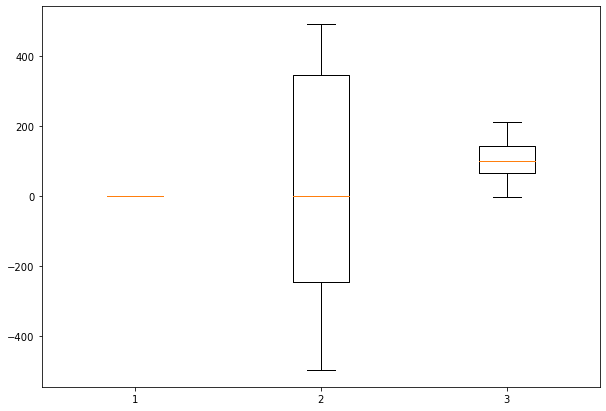

In [64]:
# Visualizing the array
fig = plt.figure(figsize =(10, 7))
plt.boxplot(X_hw)
plt.show()

In [84]:
from sklearn.preprocessing import StandardScaler

# Standardization
scaled = StandardScaler()
scaled = scaled.fit_transform(X_hw)
print(scaled)

[[-0.2496113  -1.30282506 -0.45586781]
 [ 1.76512621  0.29581669  1.61943952]
 [ 1.00031561 -1.24348777 -2.14030421]
 [ 0.53407475 -0.8965888   1.35594957]
 [-1.01372644 -0.61651149 -0.75244696]
 [-1.01381079  1.10505592  1.48749396]
 [-1.35618083  0.4803475   1.17527151]
 [ 1.46951733  0.07607568  0.96606004]
 [ 0.54266462 -1.58125622  0.77649775]
 [ 0.91666857  0.69929166  2.23547004]
 [-1.48730589 -0.39707261 -0.66717932]
 [ 1.83224825  0.92030928 -0.65329516]
 [ 1.35155967 -0.85182951 -0.72899955]
 [-0.8167878  -1.49106422  0.87492044]
 [-0.92348815  1.12936229 -1.38157454]
 [-0.91796489 -0.95988773  0.96218309]
 [-0.49542545 -0.36458463 -0.35622869]
 [ 0.2756577  -0.65224572 -1.1467773 ]
 [-0.04888068 -1.42706262 -1.15680821]
 [-0.54092903  1.0535615  -0.87191763]
 [ 0.58021232  1.07205369 -1.57115986]
 [-1.07150948  1.46855236  0.45795307]
 [-0.53772773 -0.42805154  0.80050099]
 [-0.2782087   1.41361424  0.90893011]
 [ 0.03547831 -0.23265486 -0.6991639 ]
 [ 1.18627988  0.49210868

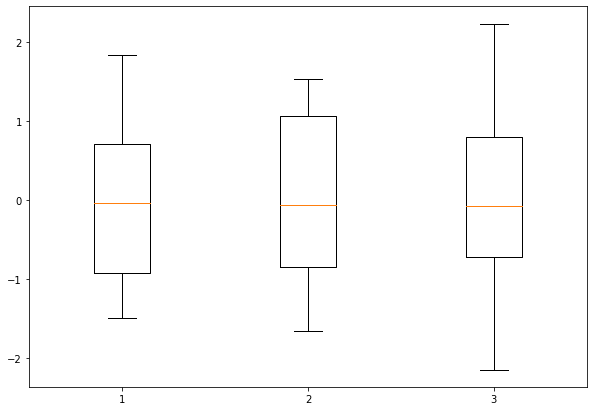

In [85]:
# Visualizing scaled data
fig = plt.figure(figsize =(10, 7))
plt.boxplot(scaled)
plt.show()

#### L1

In [91]:
## your code

reg = Lasso(alpha=0.5, random_state=SEED, max_iter=50000).fit(X_hw, y_hw)
reg_sc = Lasso(alpha=0.5, random_state=SEED, max_iter=50000).fit(scaled, y_hw)

hw_l1 = rmse(reg.predict(X_hw), y_hw)
hw_l1_sc = rmse(reg_sc.predict(scaled), y_hw)

print(hw_l1, hw_l1_sc)
print(reg.coef_)
print(reg_sc.coef_)

6.470753282414409 4.03680397150771
[ 0.         -0.00019258 -0.01747994]
[ 4.63703214  0.         -0.1260319 ]


#### L2

In [92]:
## your code

reg = Ridge(alpha=0.5, random_state=SEED, max_iter=50000).fit(X_hw, y_hw)
reg_sc = Ridge(alpha=0.5, random_state=SEED, max_iter=50000).fit(scaled, y_hw)

hw_l1 = rmse(reg.predict(X_hw), y_hw)
hw_l1_sc = rmse(reg_sc.predict(scaled), y_hw)

print(hw_l1, hw_l1_sc)
print(reg.coef_)
print(reg_sc.coef_)

6.171916884869858 3.9759655070593736
[ 1.34724952e+01 -1.50887784e-04 -1.72800879e-02]
[ 5.06550145  0.12151468 -0.60342419]


#### Summary



In [ ]:
## your observations/conclusions

> We can see that the rmse of model bacame lower when we scale the data.
> The investigation proves that scaling is really important for Linear regression models with regularization otherwise features with a higher value range will start dominating when calculating distances and will affect more than others.  In common scaling of the data makes it easy for a model to learn and understand the problem.